<a href="https://colab.research.google.com/github/NichBry25/BitcoinPricePrediction/blob/main/BTCForecasting_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Ensures results are replicable

import os
os.environ["PYTHONHASHSEED"] = "42"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

In [3]:
# Ensures results are replicable

np.random.seed(42)
random.seed(42)

In [4]:
df = pd.read_csv('btc_forecasting_dataset3.csv')

In [5]:
df

,Date,btc_price,open,high,low,volume,spx_price,xau_price,vix_price,dxy_price,...,xau_logret_lag3,xau_logret_lag7,vix_logret_lag1,vix_logret_lag3,vix_logret_lag7,dxy_logret_lag1,dxy_logret_lag3,dxy_logret_lag7,btc_ma50,btc_ma200
0,2015-07-20,277.7,273.2,278.9,271.8,46600.0,2128.30,1096.95,12.25,98.03,...,-0.009696,-0.005134,0.000000,-0.013300,-0.191274,0.000000,0.001943,0.008606,252.782,246.4990
1,2015-07-21,275.1,277.7,281.0,274.2,49050.0,2119.20,1101.41,12.22,97.33,...,0.000000,-0.002135,0.024795,0.000000,-0.038875,0.001736,0.000000,-0.002274,253.822,246.2985
2,2015-07-22,276.5,275.1,277.4,273.1,41970.0,2114.20,1093.45,12.12,97.60,...,0.000000,-0.005102,-0.002452,0.000000,-0.010526,-0.007166,0.000000,0.005469,254.838,246.2455
3,2015-07-23,275.5,276.5,277.9,274.5,35660.0,2102.20,1090.80,12.64,97.11,...,-0.033306,-0.003922,-0.008217,0.024795,-0.088455,0.002770,0.001736,0.005132,255.836,246.2995
4,2015-07-24,288.4,275.5,289.8,274.3,74360.0,2079.70,1099.10,13.74,97.24,...,0.004058,-0.009696,0.042009,-0.002452,-0.013300,-0.005033,-0.007166,0.001943,257.120,246.3675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3752,2025-10-27,114108.0,114553.9,116307.5,113868.0,70790.0,6875.16,3981.59,15.79,98.78,...,-0.003416,0.024755,0.000000,-0.055256,-0.130922,0.000000,0.000101,0.001624,114272.866,108948.3695
3753,2025-10-28,112905.8,114110.3,116076.7,112266.9,52490.0,6890.89,3952.58,16.42,98.67,...,0.000000,-0.054579,-0.036074,0.000000,-0.019945,-0.001720,0.000000,0.003443,114289.614,109095.8330
3754,2025-10-29,110024.6,112904.7,113628.7,109506.4,66990.0,6890.59,3930.38,16.92,99.22,...,0.000000,-0.007551,0.039123,0.000000,0.040038,-0.001114,0.000000,-0.000303,114259.776,109219.4925
3755,2025-10-30,108320.1,110024.9,111585.8,106371.4,80070.0,6822.34,4024.47,16.91,99.53,...,-0.032253,0.007810,0.029996,-0.036074,-0.072455,0.005559,-0.001720,0.000404,114146.908,109342.4210


Anything beyond this section ending with "1" is representing the dataframe WITHOUT macro features. While "2" is representing WITH macro features.

In [6]:
TARGET_1 = 'btc_logret'

In [7]:
FEATURES_1 = [
    'btc_price', 'open', 'high', 'low', 'volume',
    'btc_ma50', 'btc_ma200'
]

In [8]:
TARGET_2 = 'btc_logret'

In [9]:
FEATURES_2 = [
    'btc_price','open','high','low','volume',
    'spx_price','xau_price', 'vix_price', 'dxy_price',
    'spx_logret','xau_logret', 'vix_logret', 'dxy_logret',
    'spx_logret_lag1','spx_logret_lag3','spx_logret_lag7',
    'xau_logret_lag1','xau_logret_lag3','xau_logret_lag7',
    'vix_logret_lag1','vix_logret_lag3','vix_logret_lag7',
    'dxy_logret_lag1','dxy_logret_lag3','dxy_logret_lag7',
    'btc_ma50','btc_ma200'
]

# Lookback Window

In [10]:
def create_lagged_features(df, features, target, lookback):
  needed_columns = [target] + features

  temp = df[needed_columns].copy()

  lagged_cols = []

  for feature in features:
    for lag in range(1, lookback + 1):
      lagged = temp[feature].shift(lag)
      lagged.name = f'{feature}_lag{lag}'
      lagged_cols.append(lagged)

  lagged_df = pd.concat(lagged_cols, axis=1)

  temp = pd.concat([temp, lagged_df], axis=1)

  temp['y'] = temp[target]

  temp = temp.dropna().reset_index(drop=True)

  return temp

In [11]:
LOOKBACK = 60

In [12]:
df_lagged_1 = create_lagged_features(df, FEATURES_1, TARGET_1, LOOKBACK)
df_lagged_2 = create_lagged_features(df, FEATURES_2, TARGET_2, LOOKBACK)

In [13]:
df_lagged_1

,btc_logret,btc_price,open,high,low,volume,btc_ma50,btc_ma200,btc_price_lag1,btc_price_lag2,...,btc_ma200_lag52,btc_ma200_lag53,btc_ma200_lag54,btc_ma200_lag55,btc_ma200_lag56,btc_ma200_lag57,btc_ma200_lag58,btc_ma200_lag59,btc_ma200_lag60,y
0,-0.002151,232.2,232.7,234.7,230.6,53170.0,245.424,249.8010,232.7,228.6,...,246.4820,246.4535,246.4020,246.3995,246.3675,246.2995,246.2455,246.2985,246.4990,-0.002151
1,-0.004749,231.1,232.2,233.4,230.2,34470.0,244.372,249.5535,232.2,232.7,...,246.5570,246.4820,246.4535,246.4020,246.3995,246.3675,246.2995,246.2455,246.2985,-0.004749
2,0.000000,231.1,231.1,232.7,229.9,33150.0,243.384,249.3495,231.1,232.2,...,246.6680,246.5570,246.4820,246.4535,246.4020,246.3995,246.3675,246.2995,246.2455,0.000000
3,-0.020989,226.3,231.1,231.6,225.0,53430.0,242.282,249.1050,231.1,231.1,...,246.7400,246.6680,246.5570,246.4820,246.4535,246.4020,246.3995,246.3675,246.2995,-0.020989
4,0.016218,230.0,226.3,233.2,224.1,71550.0,241.250,248.8920,226.3,231.1,...,247.0360,246.7400,246.6680,246.5570,246.4820,246.4535,246.4020,246.3995,246.3675,0.016218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3692,-0.003874,114108.0,114553.9,116307.5,113868.0,70790.0,114272.866,108948.3695,114550.9,111646.1,...,101599.2420,101524.8875,101451.9845,101381.2690,101312.7005,101249.5350,101197.8075,101132.5755,101077.9710,-0.003874
3693,-0.010592,112905.8,114110.3,116076.7,112266.9,52490.0,114289.614,109095.8330,114108.0,114550.9,...,101672.0240,101599.2420,101524.8875,101451.9845,101381.2690,101312.7005,101249.5350,101197.8075,101132.5755,-0.010592
3694,-0.025850,110024.6,112904.7,113628.7,109506.4,66990.0,114259.776,109219.4925,112905.8,114108.0,...,101744.5505,101672.0240,101599.2420,101524.8875,101451.9845,101381.2690,101312.7005,101249.5350,101197.8075,-0.025850
3695,-0.015613,108320.1,110024.9,111585.8,106371.4,80070.0,114146.908,109342.4210,110024.6,112905.8,...,101813.3410,101744.5505,101672.0240,101599.2420,101524.8875,101451.9845,101381.2690,101312.7005,101249.5350,-0.015613


In [14]:
df_lagged_2

,btc_logret,btc_price,open,high,low,volume,spx_price,xau_price,vix_price,dxy_price,...,btc_ma200_lag52,btc_ma200_lag53,btc_ma200_lag54,btc_ma200_lag55,btc_ma200_lag56,btc_ma200_lag57,btc_ma200_lag58,btc_ma200_lag59,btc_ma200_lag60,y
0,-0.002151,232.2,232.7,234.7,230.6,53170.0,1958.00,1139.40,22.28,94.86,...,246.4820,246.4535,246.4020,246.3995,246.3675,246.2995,246.2455,246.2985,246.4990,-0.002151
1,-0.004749,231.1,232.2,233.4,230.2,34470.0,1958.00,1139.40,22.28,94.86,...,246.5570,246.4820,246.4535,246.4020,246.3995,246.3675,246.2995,246.2455,246.2985,-0.004749
2,0.000000,231.1,231.1,232.7,229.9,33150.0,1958.00,1139.40,22.28,94.86,...,246.6680,246.5570,246.4820,246.4535,246.4020,246.3995,246.3675,246.2995,246.2455,0.000000
3,-0.020989,226.3,231.1,231.6,225.0,53430.0,1967.00,1133.30,20.14,95.89,...,246.7400,246.6680,246.5570,246.4820,246.4535,246.4020,246.3995,246.3675,246.2995,-0.020989
4,0.016218,230.0,226.3,233.2,224.1,71550.0,1942.70,1124.80,22.44,96.28,...,247.0360,246.7400,246.6680,246.5570,246.4820,246.4535,246.4020,246.3995,246.3675,0.016218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3692,-0.003874,114108.0,114553.9,116307.5,113868.0,70790.0,6875.16,3981.59,15.79,98.78,...,101599.2420,101524.8875,101451.9845,101381.2690,101312.7005,101249.5350,101197.8075,101132.5755,101077.9710,-0.003874
3693,-0.010592,112905.8,114110.3,116076.7,112266.9,52490.0,6890.89,3952.58,16.42,98.67,...,101672.0240,101599.2420,101524.8875,101451.9845,101381.2690,101312.7005,101249.5350,101197.8075,101132.5755,-0.010592
3694,-0.025850,110024.6,112904.7,113628.7,109506.4,66990.0,6890.59,3930.38,16.92,99.22,...,101744.5505,101672.0240,101599.2420,101524.8875,101451.9845,101381.2690,101312.7005,101249.5350,101197.8075,-0.025850
3695,-0.015613,108320.1,110024.9,111585.8,106371.4,80070.0,6822.34,4024.47,16.91,99.53,...,101813.3410,101744.5505,101672.0240,101599.2420,101524.8875,101451.9845,101381.2690,101312.7005,101249.5350,-0.015613


# Train - Val - Test Split

In [15]:
def split_train_val_test(df):
  total_len = len(df)
  train_end = int(total_len * 0.70)
  val_end = int(total_len * 0.85)

  train = df.iloc[:train_end]
  val = df.iloc[train_end:val_end]
  test = df.iloc[val_end:]

  return train, val, test

In [16]:
train_1, val_1, test_1 = split_train_val_test(df_lagged_1)
train_2, val_2, test_2 = split_train_val_test(df_lagged_2)

In [17]:
train_1

,btc_logret,btc_price,open,high,low,volume,btc_ma50,btc_ma200,btc_price_lag1,btc_price_lag2,...,btc_ma200_lag52,btc_ma200_lag53,btc_ma200_lag54,btc_ma200_lag55,btc_ma200_lag56,btc_ma200_lag57,btc_ma200_lag58,btc_ma200_lag59,btc_ma200_lag60,y
0,-0.002151,232.2,232.7,234.7,230.6,53170.0,245.424,249.8010,232.7,228.6,...,246.4820,246.4535,246.4020,246.3995,246.3675,246.2995,246.2455,246.2985,246.4990,-0.002151
1,-0.004749,231.1,232.2,233.4,230.2,34470.0,244.372,249.5535,232.2,232.7,...,246.5570,246.4820,246.4535,246.4020,246.3995,246.3675,246.2995,246.2455,246.2985,-0.004749
2,0.000000,231.1,231.1,232.7,229.9,33150.0,243.384,249.3495,231.1,232.2,...,246.6680,246.5570,246.4820,246.4535,246.4020,246.3995,246.3675,246.2995,246.2455,0.000000
3,-0.020989,226.3,231.1,231.6,225.0,53430.0,242.282,249.1050,231.1,231.1,...,246.7400,246.6680,246.5570,246.4820,246.4535,246.4020,246.3995,246.3675,246.2995,-0.020989
4,0.016218,230.0,226.3,233.2,224.1,71550.0,241.250,248.8920,226.3,231.1,...,247.0360,246.7400,246.6680,246.5570,246.4820,246.4535,246.4020,246.3995,246.3675,0.016218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2582,0.011678,19379.8,19154.6,19494.4,18207.9,455130.0,19778.454,26755.8870,19154.8,19059.1,...,32303.5205,32382.8780,32459.7430,32547.5970,32635.9335,32709.5040,32783.6680,32853.1095,32918.4225,0.011678
2583,-0.010269,19181.8,19379.8,19933.9,19098.6,400450.0,19730.782,26616.2710,19379.8,19154.8,...,32203.2685,32303.5205,32382.8780,32459.7430,32547.5970,32635.9335,32709.5040,32783.6680,32853.1095,-0.010269
2584,-0.005914,19068.7,19181.7,19218.7,19000.8,123660.0,19707.158,26474.3695,19181.8,19379.8,...,32103.0340,32203.2685,32303.5205,32382.8780,32459.7430,32547.5970,32635.9335,32709.5040,32783.6680,-0.005914
2585,0.010081,19261.9,19068.8,19411.9,19066.0,140950.0,19691.718,26335.3040,19068.7,19181.8,...,31998.9000,32103.0340,32203.2685,32303.5205,32382.8780,32459.7430,32547.5970,32635.9335,32709.5040,0.010081


In [18]:
train_2

,btc_logret,btc_price,open,high,low,volume,spx_price,xau_price,vix_price,dxy_price,...,btc_ma200_lag52,btc_ma200_lag53,btc_ma200_lag54,btc_ma200_lag55,btc_ma200_lag56,btc_ma200_lag57,btc_ma200_lag58,btc_ma200_lag59,btc_ma200_lag60,y
0,-0.002151,232.2,232.7,234.7,230.6,53170.0,1958.00,1139.40,22.28,94.86,...,246.4820,246.4535,246.4020,246.3995,246.3675,246.2995,246.2455,246.2985,246.4990,-0.002151
1,-0.004749,231.1,232.2,233.4,230.2,34470.0,1958.00,1139.40,22.28,94.86,...,246.5570,246.4820,246.4535,246.4020,246.3995,246.3675,246.2995,246.2455,246.2985,-0.004749
2,0.000000,231.1,231.1,232.7,229.9,33150.0,1958.00,1139.40,22.28,94.86,...,246.6680,246.5570,246.4820,246.4535,246.4020,246.3995,246.3675,246.2995,246.2455,0.000000
3,-0.020989,226.3,231.1,231.6,225.0,53430.0,1967.00,1133.30,20.14,95.89,...,246.7400,246.6680,246.5570,246.4820,246.4535,246.4020,246.3995,246.3675,246.2995,-0.020989
4,0.016218,230.0,226.3,233.2,224.1,71550.0,1942.70,1124.80,22.44,96.28,...,247.0360,246.7400,246.6680,246.5570,246.4820,246.4535,246.4020,246.3995,246.3675,0.016218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2582,0.011678,19379.8,19154.6,19494.4,18207.9,455130.0,3669.91,1665.80,31.94,112.36,...,32303.5205,32382.8780,32459.7430,32547.5970,32635.9335,32709.5040,32783.6680,32853.1095,32918.4225,0.011678
2583,-0.010269,19181.8,19379.8,19933.9,19098.6,400450.0,3583.07,1641.76,32.02,113.31,...,32203.2685,32303.5205,32382.8780,32459.7430,32547.5970,32635.9335,32709.5040,32783.6680,32853.1095,-0.010269
2584,-0.005914,19068.7,19181.7,19218.7,19000.8,123660.0,3583.07,1641.76,32.02,113.31,...,32103.0340,32203.2685,32303.5205,32382.8780,32459.7430,32547.5970,32635.9335,32709.5040,32783.6680,-0.005914
2585,0.010081,19261.9,19068.8,19411.9,19066.0,140950.0,3583.07,1641.76,32.02,113.31,...,31998.9000,32103.0340,32203.2685,32303.5205,32382.8780,32459.7430,32547.5970,32635.9335,32709.5040,0.010081


# Data Preparation

In [19]:
def prepare_data(df):
  X = df.drop(columns=['y']).values
  y = df['y'].values

  return X, y

In [20]:
X_train_1, y_train_1 = prepare_data(train_1)
X_val_1,   y_val_1   = prepare_data(val_1)
X_test_1,  y_test_1  = prepare_data(test_1)

X_train_2, y_train_2 = prepare_data(train_2)
X_val_2,   y_val_2   = prepare_data(val_2)
X_test_2,  y_test_2  = prepare_data(test_2)

In [21]:
X_train_1.shape

(2587, 428)

In [22]:
X_train_2.shape

(2587, 1648)

# Metrics

In [23]:
def calculate_performance_metrics(y_test, y_pred):
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_test, y_pred)
  da = np.mean((y_test * y_pred) > 0)

  return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'DA': da}

# Modelling

In [24]:
from itertools import product

In [25]:
GRID = {
    "max_depth": [3, 6, 9],
    "learning_rate": [0.01, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

grid_combinations = list(product(
    GRID["max_depth"],
    GRID["learning_rate"],
    GRID["subsample"],
    GRID["colsample_bytree"],
))

In [26]:
len(grid_combinations)

24

In [27]:
def build_xgb(max_depth, learning_rate, subsample, colsample_bytree):
  model = XGBRegressor(
    n_estimators=1000, # fixed, early stopping added
    learning_rate=learning_rate,
    max_depth=max_depth,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    gamma=0.045, # fixed, 2nd order regularization
    reg_lambda=2,
    reg_alpha=1,
    objective='reg:squarederror',
    random_state=42,
    tree_method='hist',
    early_stopping_rounds=5,
  )

  return model

In [28]:
results = []

In [ ]:
for i, (depth, lr, subsample, colsample) in enumerate(grid_combinations, 1):
  print(f"\n[{i}/{len(grid_combinations)}] "
        f"depth={depth}, lr={lr}, "
        f"subsample={subsample}, colsample={colsample}")

  ## WITHOUT MACRO
  model_1 = build_xgb(depth, lr, subsample, colsample)

  model_1.fit(X_train_1, y_train_1, eval_set=[(X_val_1, y_val_1)], verbose=False)

  y_pred_1 = model_1.predict(X_test_1)
  metrics_1 = calculate_performance_metrics(y_test_1, y_pred_1)

  ## WITH MACRO
  model_2 = build_xgb(depth, lr, subsample, colsample)

  model_2.fit(X_train_2, y_train_2, eval_set=[(X_val_2, y_val_2)], verbose=False)

  y_pred_2 = model_2.predict(X_test_2)
  metrics_2 = calculate_performance_metrics(y_test_2, y_pred_2)

  results.append({
      "max_depth": depth,
      "learning_rate": lr,
      "subsample": subsample,
      "colsample_bytree": colsample,

      "MSE_1": metrics_1['MSE'],
      'MSE_2': metrics_2['MSE'],

      "RMSE_1": metrics_1["RMSE"],
      "RMSE_2": metrics_2["RMSE"],

      "MAE_1": metrics_1["MAE"],
      "MAE_2": metrics_2["MAE"],

      "DA_1": metrics_1["DA"],
      "DA_2": metrics_2["DA"],

      "Macro Better MSE": metrics_2["MSE"] < metrics_1["MSE"],
      "Macro Better RMSE": metrics_2["RMSE"] < metrics_1["RMSE"],
      "Macro Better MAE": metrics_2["MAE"] < metrics_1["MAE"],
      "Macro Better DA": metrics_2["DA"] > metrics_1["DA"],
  })


[1/24] depth=3, lr=0.01, subsample=0.8, colsample=0.8

[2/24] depth=3, lr=0.01, subsample=0.8, colsample=1.0

[3/24] depth=3, lr=0.01, subsample=1.0, colsample=0.8

[4/24] depth=3, lr=0.01, subsample=1.0, colsample=1.0

[5/24] depth=3, lr=0.1, subsample=0.8, colsample=0.8

[6/24] depth=3, lr=0.1, subsample=0.8, colsample=1.0

[7/24] depth=3, lr=0.1, subsample=1.0, colsample=0.8

[8/24] depth=3, lr=0.1, subsample=1.0, colsample=1.0

[9/24] depth=6, lr=0.01, subsample=0.8, colsample=0.8

[10/24] depth=6, lr=0.01, subsample=0.8, colsample=1.0

[11/24] depth=6, lr=0.01, subsample=1.0, colsample=0.8

[12/24] depth=6, lr=0.01, subsample=1.0, colsample=1.0

[13/24] depth=6, lr=0.1, subsample=0.8, colsample=0.8

[14/24] depth=6, lr=0.1, subsample=0.8, colsample=1.0

[15/24] depth=6, lr=0.1, subsample=1.0, colsample=0.8

[16/24] depth=6, lr=0.1, subsample=1.0, colsample=1.0

[17/24] depth=9, lr=0.01, subsample=0.8, colsample=0.8

[18/24] depth=9, lr=0.01, subsample=0.8, colsample=1.0

[19/24] 

# Results

In [ ]:
results_df = pd.DataFrame(results)

In [ ]:
results_df

,max_depth,learning_rate,subsample,colsample_bytree,MSE_1,MSE_2,RMSE_1,RMSE_2,MAE_1,MAE_2,DA_1,DA_2,Macro Better MSE,Macro Better RMSE,Macro Better MAE,Macro Better DA
0,3,0.01,0.8,0.8,0.000019,0.000018,0.004312,0.004286,0.002804,0.002787,0.981982,0.989189,True,True,True,True
1,3,0.01,0.8,1.0,0.000019,0.000019,0.004350,0.004350,0.002836,0.002836,0.981982,0.981982,False,False,False,False
2,3,0.01,1.0,0.8,0.000015,0.000015,0.003823,0.003823,0.002486,0.002486,0.990991,0.990991,False,False,False,False
3,3,0.01,1.0,1.0,0.000015,0.000015,0.003823,0.003823,0.002486,0.002486,0.990991,0.990991,False,False,False,False
4,3,0.10,0.8,0.8,0.000017,0.000016,0.004158,0.004032,0.002707,0.002625,0.981982,0.994595,True,True,True,True
5,3,0.10,0.8,1.0,0.000016,0.000016,0.004042,0.004042,0.002599,0.002599,0.990991,0.990991,False,False,False,False
6,3,0.10,1.0,0.8,0.000014,0.000014,0.003752,0.003752,0.002466,0.002466,0.983784,0.983784,False,False,False,False
7,3,0.10,1.0,1.0,0.000014,0.000014,0.003752,0.003752,0.002466,0.002466,0.983784,0.983784,False,False,False,False
8,6,0.01,0.8,0.8,0.000019,0.000018,0.004312,0.004286,0.002804,0.002787,0.981982,0.989189,True,True,True,True
9,6,0.01,0.8,1.0,0.000019,0.000019,0.004350,0.004350,0.002836,0.002836,0.981982,0.981982,False,False,False,False


In [ ]:
results_df.to_csv('xgboost_grid_results.csv') # Retraining the model is optional

In [ ]:
best_without_macro = results_df.sort_values("RMSE_1").iloc[0]
best_with_macro = results_df.sort_values("RMSE_2").iloc[0]

In [ ]:
best_without_macro

,6
max_depth,3
learning_rate,0.1
subsample,1.0
colsample_bytree,0.8
MSE_1,0.000014
MSE_2,0.000014
RMSE_1,0.003752
RMSE_2,0.003752
MAE_1,0.002466
MAE_2,0.002466


In [ ]:
best_with_macro

,6
max_depth,3
learning_rate,0.1
subsample,1.0
colsample_bytree,0.8
MSE_1,0.000014
MSE_2,0.000014
RMSE_1,0.003752
RMSE_2,0.003752
MAE_1,0.002466
MAE_2,0.002466


In [ ]:
macro_mse_win_rate = results_df["Macro Better MSE"].mean()
macro_mae_win_rate = results_df['Macro Better MAE'].mean()
macro_da_win_rate = results_df["Macro Better DA"].mean()

In [ ]:
macro_mse_win_rate

np.float64(0.25)

In [ ]:
macro_mae_win_rate

np.float64(0.25)

In [ ]:
macro_da_win_rate

np.float64(0.25)

# Retrain for Plotting

In [29]:
## WITHOUT MACRO
model_1 = build_xgb(3, 0.1, 1.0, 0.8)

model_1.fit(X_train_1, y_train_1, eval_set=[(X_val_1, y_val_1)], verbose=True)

y_pred_1 = model_1.predict(X_test_1)

## WITH MACRO
model_2 = build_xgb(3, 0.1, 1.0, 0.8)

model_2.fit(X_train_2, y_train_2, eval_set=[(X_val_2, y_val_2)], verbose=True)

y_pred_2 = model_2.predict(X_test_2)

[0]	validation_0-rmse:0.02576
[1]	validation_0-rmse:0.02348
[2]	validation_0-rmse:0.02139
[3]	validation_0-rmse:0.01955
[4]	validation_0-rmse:0.01799
[5]	validation_0-rmse:0.01654
[6]	validation_0-rmse:0.01516
[7]	validation_0-rmse:0.01392
[8]	validation_0-rmse:0.01392
[9]	validation_0-rmse:0.01392
[10]	validation_0-rmse:0.01278
[11]	validation_0-rmse:0.01180
[12]	validation_0-rmse:0.01088
[13]	validation_0-rmse:0.01006
[14]	validation_0-rmse:0.00938
[15]	validation_0-rmse:0.00938
[16]	validation_0-rmse:0.00938
[17]	validation_0-rmse:0.00868
[18]	validation_0-rmse:0.00812
[19]	validation_0-rmse:0.00760
[20]	validation_0-rmse:0.00710
[21]	validation_0-rmse:0.00669
[22]	validation_0-rmse:0.00630
[23]	validation_0-rmse:0.00600
[24]	validation_0-rmse:0.00568
[25]	validation_0-rmse:0.00538
[26]	validation_0-rmse:0.00524
[27]	validation_0-rmse:0.00524
[28]	validation_0-rmse:0.00506
[29]	validation_0-rmse:0.00506
[30]	validation_0-rmse:0.00506
[31]	validation_0-rmse:0.00506
[32]	validation_0-

# Reconstruct Prices

In [30]:
last_price = df["btc_price"].iloc[-len(y_test_1)-1]

In [31]:
def reconstruct(prices, logrets):
    out = []
    p = prices
    for r in logrets:
        p = p * np.exp(r)
        out.append(p)
    return out


In [32]:
pred_price_1 = reconstruct(last_price, y_pred_1)
pred_price_2 = reconstruct(last_price, y_pred_2)

In [33]:
actual_price = test_1["btc_price"].values[:len(pred_price_1)]

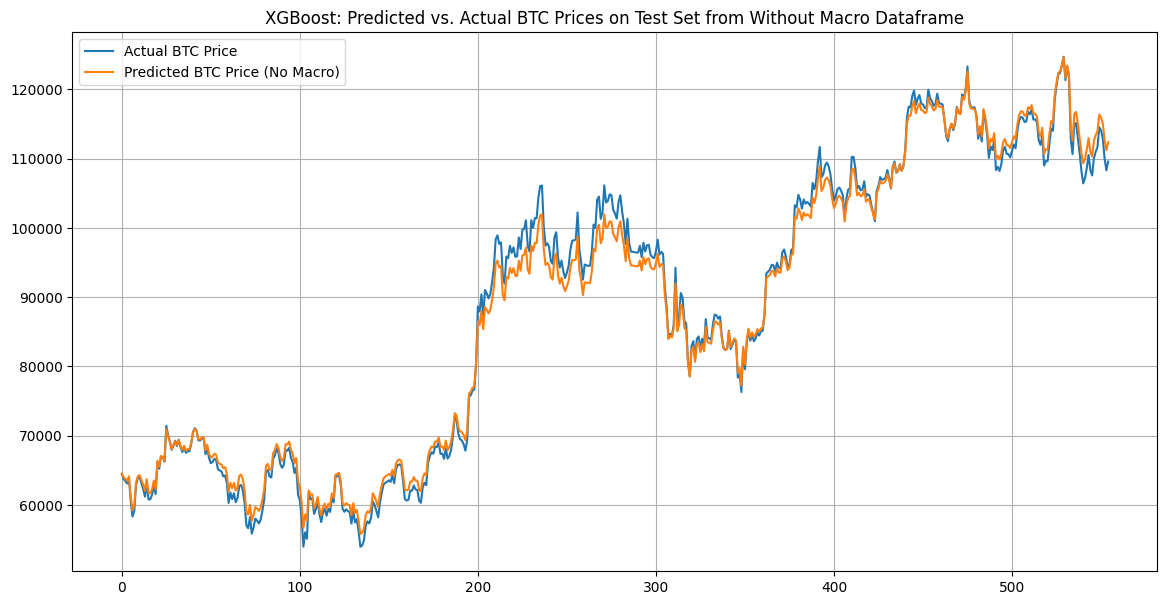

In [34]:
plt.figure(figsize=(14,7))
plt.plot(actual_price, label="Actual BTC Price")
plt.plot(pred_price_1, label="Predicted BTC Price (No Macro)")
plt.title('XGBoost: Predicted vs. Actual BTC Prices on Test Set from Without Macro Dataframe')
plt.legend(); plt.grid(); plt.show()

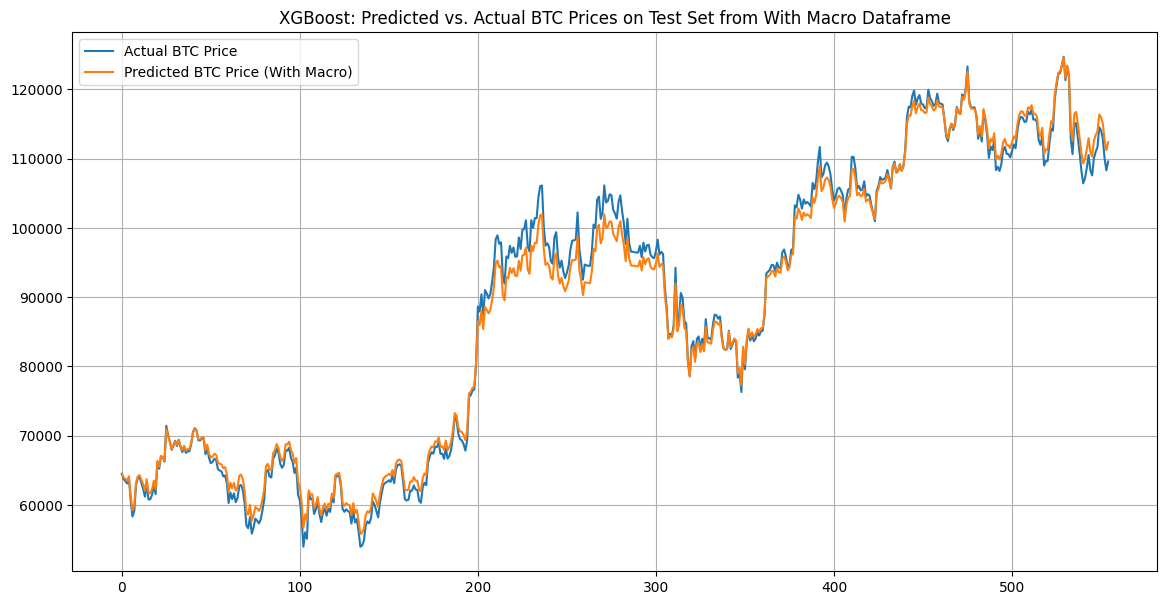

In [35]:
plt.figure(figsize=(14,7))
plt.plot(actual_price, label="Actual BTC Price")
plt.plot(pred_price_2, label="Predicted BTC Price (With Macro)")
plt.title('XGBoost: Predicted vs. Actual BTC Prices on Test Set from With Macro Dataframe')
plt.legend(); plt.grid(); plt.show()

# Statistical Significance Test

In [36]:
import statsmodels.api as sm
from statsmodels.stats.contingency_tables import mcnemar

In [37]:
def per_timestep_squared_error(y_true, y_pred):
    return (y_true - y_pred) ** 2

def hac_test_loss_difference(loss_diff, max_lag=5):
    X = np.ones(len(loss_diff))  # intercept only
    model = sm.OLS(loss_diff, X).fit(
        cov_type="HAC",
        cov_kwds={"maxlags": max_lag}
    )
    return {
        "p_value": model.pvalues[0]
    }

def mcnemar_direction_test(y_true, y_pred_nomacro, y_pred_macro):
    correct_nomacro = np.sign(y_true) == np.sign(y_pred_nomacro)
    correct_macro = np.sign(y_true) == np.sign(y_pred_macro)

    table = [
        [np.sum(correct_macro & correct_nomacro),
         np.sum(correct_macro & ~correct_nomacro)],
        [np.sum(~correct_macro & correct_nomacro),
         np.sum(~correct_macro & ~correct_nomacro)]
    ]

    result = mcnemar(table, correction=True)
    return {
        "p_value": result.pvalue
    }

In [38]:
loss_nomacro = per_timestep_squared_error(y_test_1, y_pred_1)
loss_macro   = per_timestep_squared_error(y_test_2, y_pred_2)

loss_diff = loss_macro - loss_nomacro

In [39]:
hac_result = hac_test_loss_difference(loss_diff, max_lag=5)

print(f"p-value: {hac_result['p_value']:.4f}")

p-value: nan


In [40]:
da_test = mcnemar_direction_test(y_test_1, y_pred_1, y_pred_2)

print(f"p-value: {da_test['p_value']:.4f}")

p-value: 1.0000


# Post-Hoc Statistical Tests

In [41]:
err_no_macro = pred_price_1 - actual_price
err_macro = pred_price_2 - actual_price

In [42]:
abs_err_no_macro = np.abs(err_no_macro)

In [43]:
abs_err_macro = np.abs(err_macro)

WMAE

In [44]:
test_logret = test_1['btc_logret'].values[:len(err_no_macro)]

In [45]:
rolling_vol_60 = (
    pd.Series(test_logret)
    .rolling(window=60)
    .std()
    .values
)

In [46]:
valid_idx = ~np.isnan(rolling_vol_60)

In [47]:
wmae_no_macro = np.sum(abs_err_no_macro[valid_idx] * rolling_vol_60[valid_idx]) / np.sum(rolling_vol_60[valid_idx])

In [48]:
wmae_macro = np.sum(abs_err_macro[valid_idx] * rolling_vol_60[valid_idx]) / np.sum(rolling_vol_60[valid_idx])

In [49]:
print(f"WMAE (No Macro): {wmae_no_macro:.6f}")
print(f"WMAE (With Macro): {wmae_macro:.6f}")
print(f"ΔWMAE: {wmae_macro - wmae_no_macro:.6f}")

WMAE (No Macro): 1444.833081
WMAE (With Macro): 1444.833081
ΔWMAE: 0.000000


Distributional Properties of Errors

In [50]:
def distribution_stats(errors):
    return {
        "mean": np.mean(errors),
        "median": np.median(errors),
        "std": np.std(errors),
        "iqr": np.percentile(errors, 75) - np.percentile(errors, 25),
        "min": np.min(errors),
        "max": np.max(errors)
    }

In [51]:
dist_no_macro = distribution_stats(err_no_macro)
dist_macro    = distribution_stats(err_macro)

In [52]:
dist_df = pd.DataFrame(
    [dist_no_macro, dist_macro],
    index=["No Macro", "With Macro"]
)

In [53]:
dist_df

,mean,median,std,iqr,min,max
No Macro,-233.35628,145.822596,1617.404854,2156.973984,-4227.58475,2903.176362
With Macro,-233.35628,145.822596,1617.404854,2156.973984,-4227.58475,2903.176362


Per-Model Macro Effect

In [54]:
xgb_stat_results = {
    "model": "XGBoost",
    "wmae_no_macro": wmae_no_macro,
    "wmae_macro": wmae_macro,
    "delta_wmae": wmae_macro - wmae_no_macro,
    "std_err_no_macro": dist_no_macro["std"],
    "std_err_macro": dist_macro["std"]
}

In [55]:
xgb_stat_results

{'model': 'XGBoost',
 'wmae_no_macro': np.float64(1444.8330810618627),
 'wmae_macro': np.float64(1444.8330810618627),
 'delta_wmae': np.float64(0.0),
 'std_err_no_macro': np.float64(1617.4048537688445),
 'std_err_macro': np.float64(1617.4048537688445)}

In [56]:
pd.DataFrame([xgb_stat_results]).to_csv(
    "xgboost_statistical_results.csv",
    index=False
)

# Error Visualization

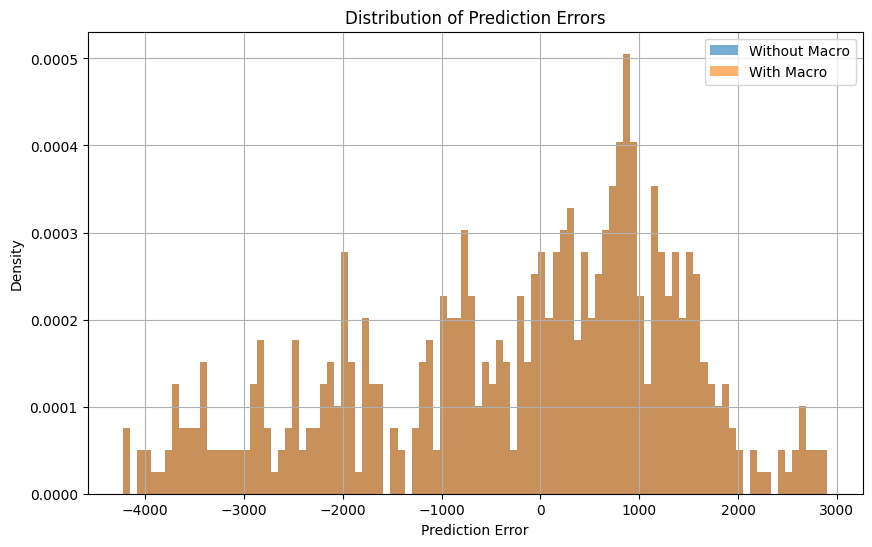

In [57]:
plt.figure(figsize=(10,6))
plt.hist(err_no_macro, bins=100, alpha=0.6, label='Without Macro', density=True)
plt.hist(err_macro, bins=100, alpha=0.6, label='With Macro', density=True)

plt.xlabel('Prediction Error')
plt.ylabel('Density')
plt.title('Distribution of Prediction Errors')
plt.legend()
plt.grid(True)

plt.show()

/tmp/ipython-input-3840640867.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


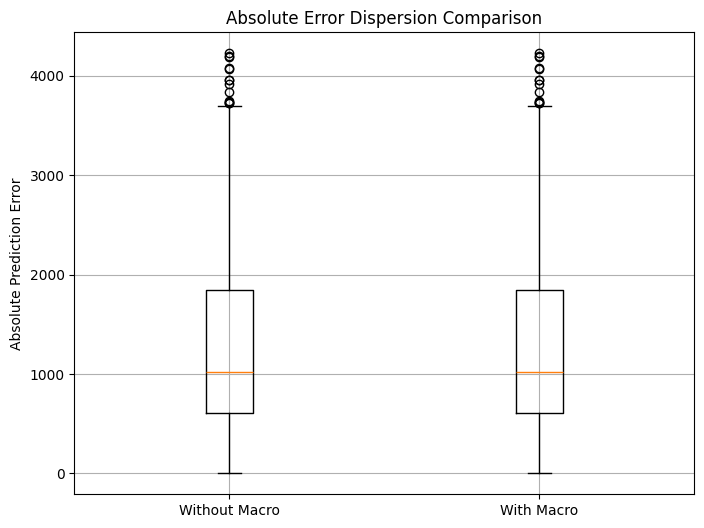

In [58]:
plt.figure(figsize=(8, 6))

plt.boxplot(
    [abs_err_no_macro, abs_err_macro],
    labels=['Without Macro', 'With Macro'],
    showfliers=True
)

plt.ylabel('Absolute Prediction Error')
plt.title('Absolute Error Dispersion Comparison')
plt.grid(True)

plt.show()

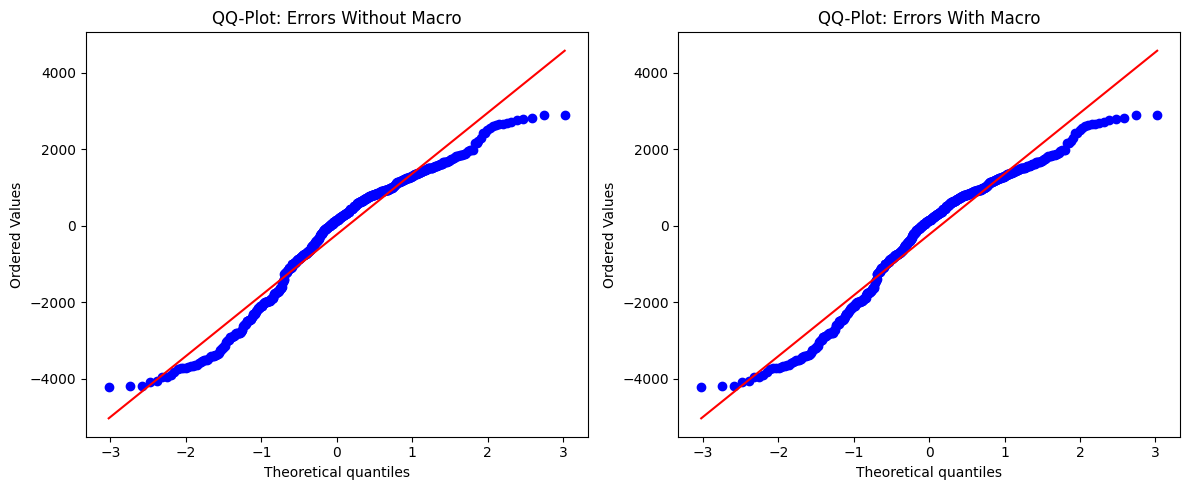

In [59]:
import scipy.stats as stats

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
stats.probplot(err_no_macro, dist="norm", plot=plt)
plt.title('QQ-Plot: Errors Without Macro')

plt.subplot(1, 2, 2)
stats.probplot(err_macro, dist="norm", plot=plt)
plt.title('QQ-Plot: Errors With Macro')

plt.tight_layout()
plt.show()